`# Exploring the Molecular Latent Space

In this demo, we will explore how generative models can allow us to generate and explore new molecular structures. In particular, we will use a encoder decoder style RNN described in Krenn et al.'s [SELFIES paper](https://iopscience.iop.org/article/10.1088/2632-2153/aba947). By modifying molecular representations in the latent space, we will be able to generate novel molecules. Note that we will train from scratch and so our model will have terrible performance.

Also note that much of this code is adapted from the [SELFIES repo](https://github.com/aspuru-guzik-group/selfies) where it is licensed under the [APACHE license](https://github.com/aspuru-guzik-group/selfies/blob/master/LICENSE).

If you are using this notebook on colab, use the following cell. Some requirements are included by default.

In [ ]:
# installation on colab

!pip install rdkit
!pip install selfies

from google.colab import drive
drive.mount('content/drive')

!cp drive/MyDrive/FOLDER_ON_DRIVE/utils.py .

If you are using the notebook locally, you'll need to install the full `requirements.txt`. If this cell doesn't work, try installing each package individually with your preferred package manager.

In [ ]:
# installation locally

!pip install -r requirements.txt

In [4]:
import torch
from torch import nn
from rdkit import Chem
import selfies as sf

from utils import (
    get_selfie_and_smiles_encodings_for_dataset,
    multiple_selfies_to_hot,
    train_model,
    one_hot_to_mol,
    smile_to_one_hot
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Our overall architecture will be a sequence-based encoder decoder model built on 3-layer RNNs. It is similar to the architecture described in [Gomez-Bombarelli et al.](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://pubs.acs.org/doi/pdf/10.1021/acscentsci.7b00572), from which the following image is taken.

![](model.png)

First we will define a fairly standard 3-layer RNN. Later on you will be able to alter the model architecture. We will be using the SELFIES molecular string encoding which has an 18 character alphabet that will be one-hot-encoded.

In [5]:
class VAEEncoder(nn.Module):

    def __init__(self, in_dimension, layer_1d, layer_2d, layer_3d,
                 latent_dimension):
        """
        Fully Connected layers to encode molecule to latent space
        """
        super(VAEEncoder, self).__init__()
        self.latent_dimension = latent_dimension

        # Reduce dimension up to second last layer of Encoder
        self.encode_nn = nn.Sequential(
            nn.Linear(in_dimension, layer_1d),
            nn.ReLU(),
            nn.Linear(layer_1d, layer_2d),
            nn.ReLU(),
            nn.Linear(layer_2d, layer_3d),
            nn.ReLU()
        )

        # Latent space mean
        self.encode_mu = nn.Linear(layer_3d, latent_dimension)

        # Latent space variance
        self.encode_log_var = nn.Linear(layer_3d, latent_dimension)

    @staticmethod
    def reparameterize(mu, log_var):
        """
        This trick is explained well here:
            https://stats.stackexchange.com/a/16338
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        """
        Pass through the Encoder
        """
        # Get results of encoder network
        h1 = self.encode_nn(x)

        # latent space
        mu = self.encode_mu(h1)
        log_var = self.encode_log_var(h1)

        # Reparameterize
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

Next we define a decoder gated recurrent unit (GRU) with a fully connected layer on top. This will use our latent space and a hidden state to generate new SELFIES.

In [3]:
class VAEDecoder(nn.Module):

    def __init__(self, latent_dimension, gru_stack_size, gru_neurons_num,
                 out_dimension):
        """
        Through Decoder
        """
        super(VAEDecoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.gru_stack_size = gru_stack_size
        self.gru_neurons_num = gru_neurons_num

        # Simple Decoder
        self.decode_RNN = nn.GRU(
            input_size=latent_dimension,
            hidden_size=gru_neurons_num,
            num_layers=gru_stack_size,
            batch_first=False)

        self.decode_FC = nn.Sequential(
            nn.Linear(gru_neurons_num, out_dimension),
        )

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters())
        return weight.new_zeros(self.gru_stack_size, batch_size,
                                self.gru_neurons_num)

    def forward(self, z, hidden):
        """
        A forward pass through the entire model.
        """

        # Decode
        l1, hidden = self.decode_RNN(z, hidden)
        decoded = self.decode_FC(l1)  # fully connected layer

        return decoded, hidden


In [4]:
# we will use a subsection of the popular QM9 dataset.
file_name_smiles = '0SelectedSMILES_QM9.txt'

# this will use a SMILES encoding
type_of_encoding = 0

print('Representation: SELFIES')
encoding_list, encoding_alphabet, largest_molecule_len, _, _, _ = \
    get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

print('--> Creating one-hot encoding...')
data = multiple_selfies_to_hot(encoding_list, largest_molecule_len,
                               encoding_alphabet)
print('Finished creating one-hot encoding.')


len_max_molec = data.shape[1]
len_alphabet = data.shape[2]
len_max_mol_one_hot = len_max_molec * len_alphabet

print(' ')
print(f"Alphabet has {len_alphabet} letters, "
      f"largest molecule is {len_max_molec} letters.")

Representation: SELFIES
--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
--> Creating one-hot encoding...
Finished creating one-hot encoding.
 
Alphabet has 18 letters, largest molecule is 21 letters.


We can modify training hyperparameters with these dicitionaries.

In [5]:
batch_size = 100

decoder_parameters = {
  'latent_dimension': 50,
  'gru_neurons_num': 99,
  'gru_stack_size': 1,
}

encoder_parameters = {
  'layer_1d': 100,
  'layer_2d': 100,
  'layer_3d': 100,
  'latent_dimension': 50
}

training_parameters = {
  'KLD_alpha': 1.0e-05,
  'lr_enc': 0.0001,
  'lr_dec': 0.0001,
  'num_epochs': 3, # not nearly enough to get decent performance
  'sample_num': 1000
}

First we will define our encoder and decoder networks and put them on our device (if available).

In [6]:
vae_encoder = VAEEncoder(in_dimension=len_max_mol_one_hot,
                         **encoder_parameters).to(device)
vae_decoder = VAEDecoder(**decoder_parameters,
                         out_dimension=len(encoding_alphabet)).to(device)

Next we will train our model, the specifics of this process are in the `utils.py` file and you can look if interested.

In [7]:
data = torch.tensor(data, dtype=torch.float).to(device)

train_valid_test_size = [0.5, 0.5, 0.0]
data = data[torch.randperm(data.size()[0])]
idx_train_val = int(len(data) * train_valid_test_size[0])
idx_val_test = idx_train_val + int(len(data) * train_valid_test_size[1])

data_train = data[0:idx_train_val]
data_valid = data[idx_train_val:idx_val_test]

print("start training")
train_model(**training_parameters,
            vae_encoder=vae_encoder,
            vae_decoder=vae_decoder,
            batch_size=batch_size,
            data_train=data_train,
            data_valid=data_valid,
            alphabet=encoding_alphabet,
            type_of_encoding=type_of_encoding,
            sample_len=len_max_molec,
            device=device)


start training
num_epochs:  3
Epoch: 0,  Batch: 0 / 660,	(loss: 2.8944	| quality: 7.3333 | quality_valid: 7.8476)	ELAPSED TIME: 0.48079
Epoch: 0,  Batch: 30 / 660,	(loss: 2.8304	| quality: 14.0476 | quality_valid: 12.8629)	ELAPSED TIME: 0.67860
Epoch: 0,  Batch: 60 / 660,	(loss: 2.7491	| quality: 19.5238 | quality_valid: 23.1943)	ELAPSED TIME: 0.67434
Epoch: 0,  Batch: 90 / 660,	(loss: 2.3950	| quality: 38.6667 | quality_valid: 36.6533)	ELAPSED TIME: 0.65170
Epoch: 0,  Batch: 120 / 660,	(loss: 1.9397	| quality: 39.7619 | quality_valid: 40.3867)	ELAPSED TIME: 0.68151
Epoch: 0,  Batch: 150 / 660,	(loss: 1.8120	| quality: 53.8095 | quality_valid: 53.2533)	ELAPSED TIME: 0.79152
Epoch: 0,  Batch: 180 / 660,	(loss: 1.6999	| quality: 56.5714 | quality_valid: 55.7905)	ELAPSED TIME: 0.96082
Epoch: 0,  Batch: 210 / 660,	(loss: 1.6222	| quality: 59.5714 | quality_valid: 58.2552)	ELAPSED TIME: 1.06744
Epoch: 0,  Batch: 240 / 660,	(loss: 1.5825	| quality: 58.6667 | quality_valid: 59.8971)	ELAPSED T

[16:58:01] SMILES Parse Error: syntax error while parsing: [#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2]
[16:58:01] SMILES Parse Error: Failed parsing SMILES '[#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2]' for input: '[#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2][#Branch2]'
[16:58:01] SMILES Parse Error: syntax error while parsing: [=N][=N][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[16:58:01] SMILES Parse Error: Failed parsing SMILES '[=N][=N][nop][nop][nop]

Validity: 4.00000 % | Diversity: 0.40000 % | Reconstruction: 65.76190 %
Epoch: 1,  Batch: 0 / 660,	(loss: 1.1769	| quality: 67.4286 | quality_valid: 65.3181)	ELAPSED TIME: 0.02905
Epoch: 1,  Batch: 30 / 660,	(loss: 1.2409	| quality: 63.9524 | quality_valid: 65.3848)	ELAPSED TIME: 0.64356
Epoch: 1,  Batch: 60 / 660,	(loss: 1.2125	| quality: 65.4286 | quality_valid: 65.4286)	ELAPSED TIME: 0.69398
Epoch: 1,  Batch: 90 / 660,	(loss: 1.1347	| quality: 67.8095 | quality_valid: 65.6590)	ELAPSED TIME: 0.70206
Epoch: 1,  Batch: 120 / 660,	(loss: 1.2202	| quality: 65.3333 | quality_valid: 65.2819)	ELAPSED TIME: 0.68872
Epoch: 1,  Batch: 150 / 660,	(loss: 1.1987	| quality: 65.6667 | quality_valid: 65.1657)	ELAPSED TIME: 0.72748
Epoch: 1,  Batch: 180 / 660,	(loss: 1.2019	| quality: 65.3333 | quality_valid: 65.5943)	ELAPSED TIME: 0.74186
Epoch: 1,  Batch: 210 / 660,	(loss: 1.1894	| quality: 65.6667 | quality_valid: 65.9790)	ELAPSED TIME: 0.72729
Epoch: 1,  Batch: 240 / 660,	(loss: 1.2234	| quality:

Here is where things get interesting. We can input any molecule we are interested in by specifying the appropriate SELFIE string. In this case, we will start with a SMILE, convert it into a SMILE, and then feed it into our encoder. Below I am using ethanol but if you'd like to explore a different molecule you can draw a molecule and covert it to a SMILE using [LigParGen](http://zarbi.chem.yale.edu/ligpargen/moleculeDraw.html).

We will then convert this SMILE to a one-hot-encoding in the SELFIES style representation.

In [8]:
input_smile = "CCO"

hot = smile_to_one_hot(input_smile, largest_molecule_len, encoding_alphabet)
hot.shape

torch.Size([1, 21, 18])

This does give us the expected shape, with dimensions of batch size, largest molecule, and alphabet size.

Using rdkit, we can also visualize our molecule.

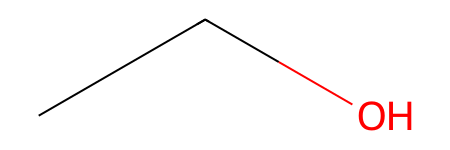

In [9]:
Chem.MolFromSmiles(input_smile)

Next let's create a latent representation using the encoder! Here we will need to insert an extra singleton dimension to imitate the batch size.

In [10]:
hot = smile_to_one_hot(input_smile, largest_molecule_len, encoding_alphabet)

latent_representation = vae_encoder(torch.flatten(hot, 1))[0]

latent_w_fake_batch = torch.unsqueeze(latent_representation, 0)

latent_w_fake_batch.shape

torch.Size([1, 1, 50])

This is a 50-dimensional encoding of our molecule! The first two dimensions are the batch size and the GRU stack size.

Next let's decode our latent space and see how we did! Again, we will be using the SMILES representation because they are a bit easier to read. First we initialize the hidden state and then iterate until we have generated a full sequence.

In [11]:
hidden = vae_decoder.init_hidden(batch_size=1)

# decoding from RNN N times, where N is the length of the largest
# molecule (all molecules are padded)
out_one_hot = torch.zeros((1, len_max_molec, len_alphabet), device=device)
for seq_index in range(len_max_molec):
    out_one_hot_line, hidden = vae_decoder(latent_w_fake_batch, hidden)
    out_one_hot[:, seq_index, :] = out_one_hot_line[0]

This yields a one-hot-encoding. Let's convert that into a SMILE and draw it to see how we did.

CCC


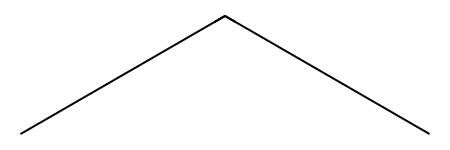

In [12]:
selfie = one_hot_to_mol(out_one_hot, encoding_alphabet)
smile = sf.decoder(selfie)
print(smile)
Chem.MolFromSmiles(smile)

We got the length right, but the chemistry wrong. Given that we barely trained our model at all, that's not bad. Let's try modifying the latent representation and seeing what changes.

CCCCCC=C


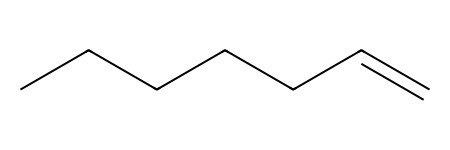

In [13]:
new_latent = latent_w_fake_batch * 2

hidden = vae_decoder.init_hidden(batch_size=1)

# decoding from RNN N times, where N is the length of the largest
# molecule (all molecules are padded)
out_one_hot = torch.zeros((1, len_max_molec, len_alphabet), device=device)
for seq_index in range(len_max_molec):
    out_one_hot_line, hidden = vae_decoder(new_latent, hidden)
    out_one_hot[:, seq_index, :] = out_one_hot_line[0]

selfie = one_hot_to_mol(out_one_hot, encoding_alphabet)
smile = sf.decoder(selfie)
print(smile)
Chem.MolFromSmiles(smile)

Our model has generated a brand new molecule! We can now head to lab and start synthesizing!

While obviously our model performed pretty poorly, this overall approach of exploring molecular latent spaces is quite common in AI for chemistry. Prior work has found that in a properly trained model, nearby points in the latent space have similar chemical properties, meaning our latent representation is really encoding chemistry.

The next step would be to start optimizing a property across the latent space using a gradient-free optimization technique like Gaussian processes.

Hopefully this toy example has taught you something about how chemists are using AI to design brand new molecules!